In [1]:
from main import read_in_blicks, BOUNDARY, eval_auc
import scorers
import datasets
import informants
import pandas as pd
import numpy as np
import random
import torch
from BayesianGLM import BayesianLearner
from tqdm import tqdm
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amanirmk/anaconda3/envs/informants/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_type = 'atr_harmony'
lexicon_path = f'data/hw/{feature_type}_lexicon.txt'
phoneme_feature_path = f'data/hw/{feature_type}_features.txt'
ngram_feature_path = f'data/hw/{feature_type}_feature_weights.txt'
dataset = datasets.load_lexicon(lexicon_path, min_length=2, max_length=5)
mf_scorer = scorers.MeanFieldScorer(
    dataset, 
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
)
hw_scorer = scorers.HWScorer(
    dataset, 
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
)
informant = informants.HWInformant(dataset, hw_scorer)

Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512
feature type:  atr_harmony
Reading phoneme features from: data/hw/atr_harmony_features.txt
Loading ngram features from: data/hw/atr_harmony_feature_weights.txt


In [3]:
def load_eval_dataset():

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    eval_dataset_path = 'test_set.csv'
    print(f'Reading eval items from:\t{eval_dataset_path}')
    items = read_in_blicks(eval_dataset_path)


    # Get phonemes
    phonemes = [[BOUNDARY] + item + [BOUNDARY] for item in items]
    # Encode items
    encoded_items = [dataset.vocab.encode(phon) for phon in phonemes]
    # Get labels with HW oracle
    labels = [informant.judge(encod) for encod in encoded_items]
    # Featurize items
    featurized_items = [mf_scorer._featurize(encod).nonzero()[0] for encod in encoded_items]
    # Get num features

    # Get dataframe of results
    eval_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'encoded': encoded_items,
        'featurized': featurized_items,
    })

    return eval_dataset

In [4]:
data = load_eval_dataset()

Reading eval items from:	test_set.csv


In [8]:
learner = BayesianLearner(
        dataset, 
        seed=0,
        strategy="train", 
        linear_train_dataset=dataset.data,
        index_of_next_item=0,
        feature_type=feature_type, 
        phoneme_feature_file=phoneme_feature_path,
        track_params=False
    )
learner.initialize()

Reading phoneme features from: data/hw/atr_harmony_features.txt


I0000 00:00:1700153595.455388       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [ ]:
def get_auc(learner, eval_dataset):
    # Learner.cost() is used to get predictions for the test set
    costs = [learner.cost(encod) for encod in eval_dataset['encoded'].values]
    auc = eval_auc(costs, eval_dataset['label'].values)
    return auc

In [ ]:
n_samples = 50
n_candidates = 10
linear_train_dataset = dataset.data
eval_dataset = load_eval_dataset()

csv = "testrun-bayesian.csv"

strategies = [
    "train",
    "unif",
    "entropy",
    "entropy_pred",
    "eig",
    "eig_train_mixed",
    "eig_train_model",
    "eig_train_history",
    "kl",
    "kl_train_mixed",
    "kl_train_model",
    "kl_train_history",
]

In [ ]:
pd.DataFrame({"seed":[], "strategy":[], "auc":[]}).to_csv(csv, index=False)

In [ ]:
seed = 2
for strategy in strategies:
    print(strategy)
    print("----------------")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    dataset.random.seed(seed)

    learner = BayesianLearner(
        dataset, 
        seed=seed,
        strategy=strategy, 
        linear_train_dataset=dataset.data,
        index_of_next_item=0,
        feature_type=feature_type, 
        phoneme_feature_file=phoneme_feature_path,
        track_params=False
    )
    learner.initialize()
    aucs = []
    for _ in tqdm(range(n_samples)):
        cand = learner.propose(n_candidates)
        judgment = informant.judge(cand)
        learner.observe(cand, judgment)
        auc = get_auc(learner, eval_dataset)
        aucs.append(auc)
    pd.DataFrame.from_dict([{
        "seed": seed,
        "strategy": strategy,
        "auc": aucs,
    }]).to_csv(csv, mode="a", index=False, header=False)

In [14]:
seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
dataset.random.seed(seed)

learner = BayesianLearner(
    dataset, 
    seed=seed,
    strategy="train", 
    linear_train_dataset=dataset.data,
    index_of_next_item=0,
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
    track_params=False
)
learner.initialize()
prior_auc = get_auc(learner, eval_dataset)

Reading phoneme features from: data/hw/atr_harmony_features.txt


0.5113636363636364

In [46]:
import time

seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
dataset.random.seed(seed)

learner = BayesianLearner(
    dataset, 
    seed=seed,
    strategy="eig", 
    linear_train_dataset=dataset.data,
    index_of_next_item=0,
    feature_type=feature_type, 
    phoneme_feature_file=phoneme_feature_path,
    track_params=False
)
learner.initialize()

n = 50
times = []
for i in range(n):
    t1 = time.time()
    cand = learner.propose(n_candidates)
    judgment = informant.judge(cand)
    learner.observe(cand, judgment)
    times.append(time.time() - t1)
    print(i, times[-1])

Reading phoneme features from: data/hw/atr_harmony_features.txt
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

I0000 00:00:1699983079.838090       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.847344       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.850344       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.860352       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.863638       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.863856       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.868030       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.872035       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699983079.935325       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


0 24.375005960464478
1 14.852896928787231
2 14.71380615234375
3 14.959824085235596
4 14.263999938964844
5 14.799360036849976
6 14.842098951339722
7 15.409324169158936
8 14.653210878372192
9 16.190216064453125
10 15.518265008926392
11 16.55946111679077
12 14.202646017074585
13 16.8365478515625
14 15.43100094795227
15 15.089236974716187
16 14.994263172149658
17 15.934194326400757
18 15.119837999343872
19 15.137164831161499
20 16.371457815170288
21 16.478384733200073
22 15.26209568977356
23 16.32953190803528
24 12.756375789642334
25 16.137248039245605
26 15.946460008621216
27 15.348604917526245
28 15.854743719100952
29 15.852835893630981
30 16.19211506843567
31 12.356310606002808
32 16.481779098510742
33 17.660640001296997
34 15.535004138946533
35 12.81368112564087
36 16.381058931350708
37 14.969351053237915
38 16.241916179656982
39 16.34433603286743
40 16.059680938720703
41 16.427067756652832
42 16.08246898651123
43 17.224807262420654
44 14.688405990600586
45 17.477827787399292
46 16.253

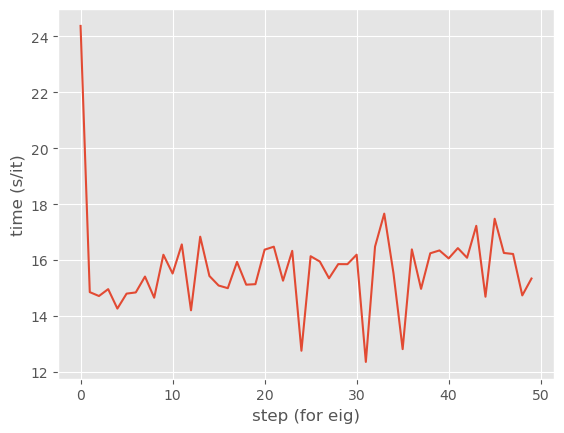

In [48]:
plt.plot(range(n), times)
plt.xlabel("step (for eig)")
plt.ylabel("time (s/it)")
plt.savefig("time_per_step.pdf", bbox_inches="tight")

(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)
(3, 51)


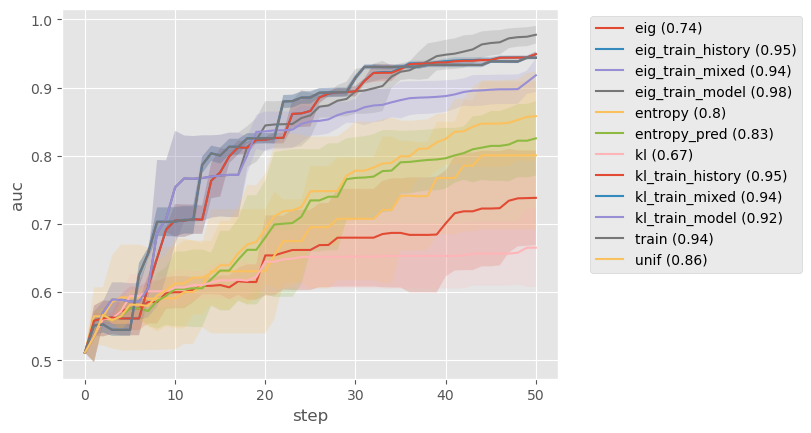

In [34]:
data = pd.read_csv(csv)
plt.style.use("ggplot")
n_seeds = len(data["seed"].unique())
for strategy, auc_group in data.groupby("strategy")["auc"]:
    aucs = np.array([eval(l) for l in auc_group.values])
    aucs = np.concatenate((np.full((n_seeds,1), prior_auc).T, aucs.T)).T
    mean_auc = aucs.mean(axis=0)
    ci_rad = 1.96*aucs.std(axis=0)/np.sqrt(n_seeds)
    x = range(len(mean_auc))
    plt.plot(x, mean_auc, label=f"{strategy} ({round(np.max(mean_auc), 2)})")
    plt.fill_between(x, mean_auc-ci_rad, mean_auc+ci_rad, alpha=0.2)
plt.ylabel("auc")
plt.xlabel("step")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("testrun.pdf", bbox_inches="tight")